In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer
from scipy import interpolate
from scipy.interpolate import interp1d


In [2]:
MAX_DEPTH=6
NUMESTIMATORS=2

In [3]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(X_test,y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS


def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [4]:
def getacc(c1,c2,p1,p2,p3,f1,f2):
    s1=f1(1-c1)
    s2=f2(1-c2)
    A=(c1*c2*(1-p1)*(1-p2))/((c1*(1-p1)+(1-s1)*p1)*(c2*(1-p2)+(1-s2)*p2))
    B=(1-s1)*p1 - (1-c1)*(1-p1) + (1-s2)*p2 - (1-c2)*(1-p2) + p3
    return s1*p1+s2*p2+ A*B

In [5]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc,y_test,y_pred

In [6]:
def getFmap(CLFstar,X,y):
    auc_=[]
    ROC={}
    fpr_ = np.linspace(0, 1, num=20, endpoint=True)
    for run in np.arange(1000):
        clf=CLFstar
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        f = interp1d(fpr, tpr)
        auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
        ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_)}

    TPR=[]
    for a in ROC.keys():
        TPR=np.append(TPR,ROC[a]['tpr'])
    TPR=TPR.reshape(int(len(TPR)/len(fpr_)),len(fpr_))
    medTPR=np.median(TPR,axis=0)
    return interpolate.interp1d(fpr_,np.median(TPR,axis=0) ), ROC

In [7]:
Ef=pd.read_excel('./2022summer/adeptphase3/BIOTYPES_HC_withBiofactors_21_1008.xlsx')
Ef.columns

Index(['Subid', 'Biotype Cluster Membership',
       'Biotype Cluster Membership String', 'DSM', 'DSM String', 'Age', 'Sex',
       'EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'LATENCY',
       'ANTISACCADE', 'BACS', 'SST', 'IEA'],
      dtype='object')

In [8]:
Ef_=Ef[['Subid',#'Age', 'Sex',
       'EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'LATENCY',
       'ANTISACCADE', 'BACS', 'SST', 'IEA']]

In [9]:
Ef.head()

,Subid,Biotype Cluster Membership,Biotype Cluster Membership String,DSM,DSM String,Age,Sex,EEG1,EEG2,EEG3,EEG4,EEG5,EEG6,LATENCY,ANTISACCADE,BACS,SST,IEA
0,1,2,BT2,1.0,SZP,21.0,1.0,1.12820,1.87300,2.33730,-0.21366,-1.71850,0.82298,1.97720,0.81046,-2.50360,0.46935,1.25487
1,4,5,BT3,5.0,SADP,19.0,1.0,0.21344,0.98380,-0.01598,0.29054,0.40746,0.16553,-0.56255,0.57429,0.28269,0.26599,0.60817
2,17,2,BT2,2.0,BPP,27.0,2.0,0.46442,-0.77002,0.70273,-0.11653,0.62982,0.28553,-1.30490,1.15190,-1.17130,-1.36430,0.53097
3,40,3,HC,3.0,HC,60.0,1.0,-0.49419,-1.60390,0.69619,0.34431,-0.37430,0.04882,-0.17613,-1.15000,1.44260,NaN,-1.11014
4,50,3,HC,3.0,HC,48.0,1.0,0.33141,-0.67916,1.07570,-0.35825,0.19952,0.62360,NaN,NaN,-0.28807,-0.14360,-0.33049


In [10]:
Ef['Biotype Cluster Membership String'].value_counts()

HC     895
BT3    646
BT2    631
BT1    630
Name: Biotype Cluster Membership String, dtype: int64

In [11]:
Ef['Biotype Cluster Membership'].value_counts()

3    895
5    646
2    631
1    630
Name: Biotype Cluster Membership, dtype: int64

In [12]:
xf=pd.read_csv('./2022summer/adeptphase2/Cognition.csv',index_col=0)
xf.index.name='subject_id'
df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df=df.join(xf)#.head()
df=df.join(Ef_.set_index('Subid'))

In [13]:
df.head()

,Biotype,project,panss_p1,panss_p2,panss_p3,panss_p4,panss_p5,panss_p6,panss_p7,panss_n1,...,EEG2,EEG3,EEG4,EEG5,EEG6,LATENCY,ANTISACCADE,BACS,SST,IEA
subject_id,,,,,,,,,,,,,,,,,,,,,
1,2,1,4.0,3.0,4.0,1.0,3.0,2.0,1.0,4.0,...,1.87300,2.33730,-0.21366,-1.71850,0.82298,1.97720,0.81046,-2.50360,0.46935,1.25487
4,3,1,3.0,1.0,3.0,1.0,2.0,2.0,1.0,3.0,...,0.98380,-0.01598,0.29054,0.40746,0.16553,-0.56255,0.57429,0.28269,0.26599,0.60817
17,2,1,2.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,...,-0.77002,0.70273,-0.11653,0.62982,0.28553,-1.30490,1.15190,-1.17130,-1.36430,0.53097
53,2,1,4.0,3.0,5.0,2.0,1.0,3.0,1.0,5.0,...,-0.49290,0.83015,0.29458,0.95910,0.07574,1.70840,1.67910,-1.80260,-1.32620,2.11076
73,2,1,6.0,5.0,6.0,4.0,5.0,6.0,6.0,1.0,...,0.96811,0.18825,1.58710,0.06071,-0.57604,-1.22850,0.83388,0.07678,-2.81020,0.99180


In [14]:
df.Biotype.value_counts()

3    646
2    631
1    630
Name: Biotype, dtype: int64

In [15]:
#df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df.columns

Index(['Biotype', 'project', 'panss_p1', 'panss_p2', 'panss_p3', 'panss_p4',
       'panss_p5', 'panss_p6', 'panss_p7', 'panss_n1', 'panss_n2', 'panss_n3',
       'panss_n4', 'panss_n5', 'panss_n6', 'panss_n7', 'panss_g1', 'panss_g2',
       'panss_g3', 'panss_g4', 'panss_g5', 'panss_g6', 'panss_g7', 'panss_g8',
       'panss_g9', 'panss_g10', 'panss_g11', 'panss_g12', 'panss_g13',
       'panss_g14', 'panss_g15', 'panss_g16', 'madrs_1', 'madrs_2', 'madrs_3',
       'madrs_4', 'madrs_5', 'madrs_6', 'madrs_7', 'madrs_8', 'madrs_9',
       'madrs_10', 'young_1', 'young_2', 'young_3', 'young_4', 'young_5',
       'young_6', 'young_7', 'young_8', 'young_9', 'young_10', 'young_11',
       'sfs_setotal', 'sfs_ictotal', 'sfs_ipcptotal', 'sfs_ipcctotal',
       'sfs_retotal', 'sfs_prototal', 'sfs_oetotal', 'DX', 'Age', 'Sex',
       'BSNIP1vs2', 'Psychosis', 'BACS_COMP_Z_within',
       'BACS_Verb_Mem_within_imputed', 'BACS_Dig_Seq_z_within_imputed',
       'BACS_Tok_Mot_z_within_imputed', 'BA

In [16]:
pd.read_csv('combined_bsnip.csv',index_col=0).columns

Index(['DSM', 'Biotype', 'project', 'panss_p1', 'panss_p2', 'panss_p3',
       'panss_p4', 'panss_p5', 'panss_p6', 'panss_p7', 'panss_n1', 'panss_n2',
       'panss_n3', 'panss_n4', 'panss_n5', 'panss_n6', 'panss_n7', 'panss_g1',
       'panss_g2', 'panss_g3', 'panss_g4', 'panss_g5', 'panss_g6', 'panss_g7',
       'panss_g8', 'panss_g9', 'panss_g10', 'panss_g11', 'panss_g12',
       'panss_g13', 'panss_g14', 'panss_g15', 'panss_g16', 'madrs_1',
       'madrs_2', 'madrs_3', 'madrs_4', 'madrs_5', 'madrs_6', 'madrs_7',
       'madrs_8', 'madrs_9', 'madrs_10', 'young_1', 'young_2', 'young_3',
       'young_4', 'young_5', 'young_6', 'young_7', 'young_8', 'young_9',
       'young_10', 'young_11', 'sfs_setotal', 'sfs_ictotal', 'sfs_ipcptotal',
       'sfs_ipcctotal', 'sfs_retotal', 'sfs_prototal', 'sfs_oetotal'],
      dtype='object')

In [17]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df
[p1,p2,p3]=(df0.Biotype.value_counts()/df0.Biotype.value_counts().sum()).values

In [18]:
df.Biotype.value_counts()
# 3 is HC

3    334
1    293
2    254
Name: Biotype, dtype: int64

In [19]:
def getRES(df0,MAX_DEPTH=6,NUMESTIMATORS=2,MODELfile='model23eeg.mod'):
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==2)+0 for x in y ]

    MODEL={}
    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f1,ROCA=getFmap(CLFstarA,X,y)
    
    MODEL[2]={'estimator':CLFstarA,'fmap':f1,'rocs':ROCA}

    #df=df0[df0.Biotype.isin([1,5])]
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==3)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f2,ROCB=getFmap(CLFstarB,X,y)
    MODEL[3]={'estimator':CLFstarB,'fmap':f2,'rocs':ROCB}

    R=[]
    for i in np.arange(.7,.99,.01):
        for j in np.arange(.7,.99,.01):
            R=np.append(R,[i,j,getacc(i,j,p1,p2,p3,f1,f2)])
    R=pd.DataFrame(R.reshape(len(R)//3,3))
    R.columns=['c1','c2','acc']
    R['s1']=f1(1-R.c1)
    R['s2']=f2(1-R.c2)


    X_test=df.values.astype(np.float32)
    L=[]

    for sample_id in np.arange(len(X_test)):
        Node_index=[]
        for i in CLFstarA.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)

        for i in CLFstarB.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)
        L=np.append(L,len(set(Node_index))-2)
    L=np.array(L)
    #print(np.mean(L),np.median(L))
    #sns.displot(L);


    RES=R.sort_values('acc',ascending=False).head(1)
    RES['nq_mean']=np.mean(L)
    RES['nq_median']=np.median(L)
    
    if MODELfile is not None:
        import dill
        with open(MODELfile, "wb") as dill_file:
            dill.dump(MODEL, dill_file)
    #dill_file.close()
    
    return RES, ROCA, ROCB, CLFstarA, CLFstarB

In [20]:
Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10)
Rs

,c1,c2,acc,s1,s2,nq_mean,nq_median
775,0.95,0.95,0.902611,0.930809,0.854516,26.524404,27.0


In [21]:
# load model
import dill
with open('model23eeg.mod','rb') as f:
    M=dill.load(f)

    

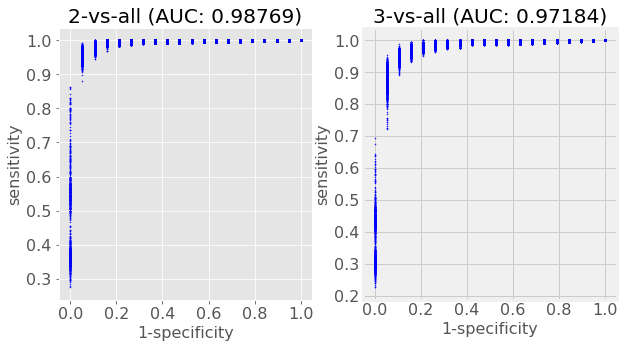

In [22]:

def pltROC(M,VAR,ax,FS=14):
    plt.style.use('fivethirtyeight')
    ROC=M[VAR]['rocs']   
    auc=[]
    for key,crv in ROC.items():
        ax.plot(crv['fpr'],crv['tpr'],'.',ms=1,color='b')
        auc=np.append(auc,key)
    ax.set_xlabel('1-specificity',fontsize=FS)
    ax.set_ylabel('sensitivity',fontsize=FS)
    plt.setp(ax.get_xticklabels(), fontsize=FS);
    plt.setp(ax.get_yticklabels(), fontsize=FS);
    ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );
    
#plt.style.use('seaborn-whitegrid')
fig=plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
pltROC(M,2,plt.gca(),FS=16)

plt.subplot(1,2,2)
pltROC(M,3,plt.gca(),FS=16)

plt.savefig('ROC2vall_3vall_clinical_cognitive_eeg.png',dpi=400,bbox_inches='tight',transparent=True)


In [23]:
CF=np.zeros([3,3])
s2=Rs.s1.values[0]
s3=Rs.s2.values[0]
c2=Rs.c1.values[0]
c3=Rs.c2.values[0]
CF=[[c2*c3,1-c2,c2*(1-c3)],[(1-s2)*(1-s3),s2,(1-s2)*s3],[c2*(1-s3),1-c2,c2*s3]]

CF=pd.DataFrame(CF,columns=['B1','B2','B3'])
CF.index=CF.columns
CF

,B1,B2,B3
B1,0.902500,0.050000,0.047500
B2,0.010066,0.930809,0.059125
B3,0.138210,0.050000,0.811790


In [25]:
feature_names=df.columns
feature_names=feature_names[1:]
feature_names[62]

'BSNIP1vs2'

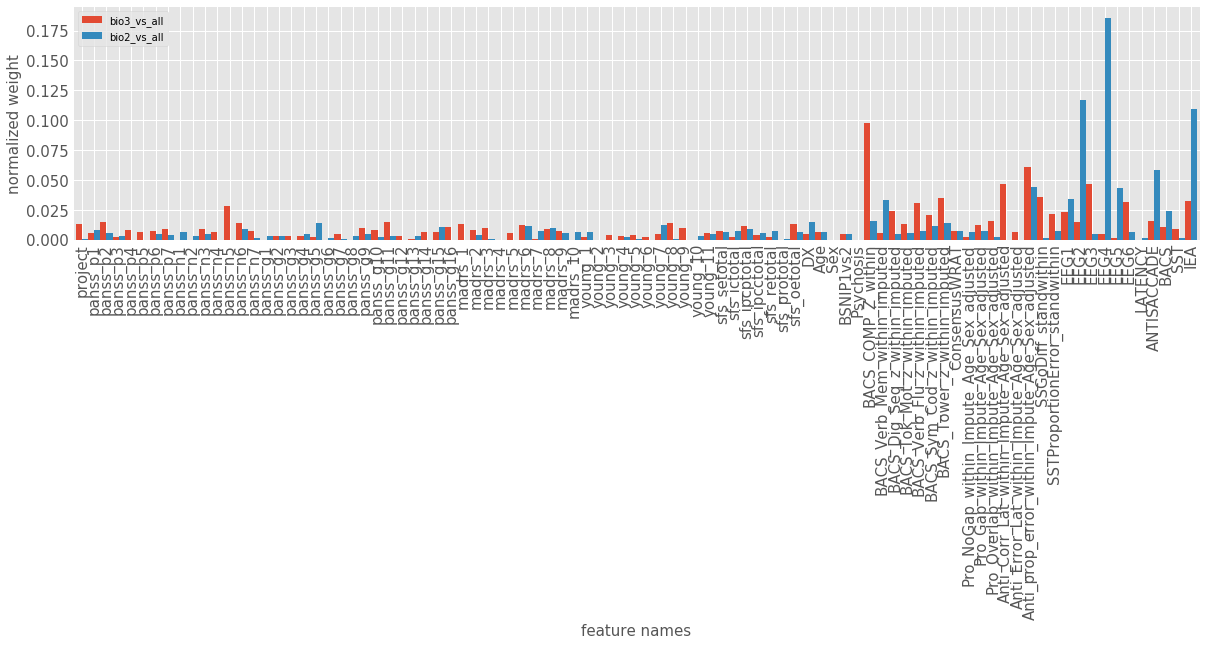

In [26]:
IMP2=M[2]['estimator'].feature_importances_
IMP3=M[3]['estimator'].feature_importances_
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
IMPdf=pd.DataFrame(IMP2,IMP3,columns=['imp_2']).reset_index()
IMPdf.columns=['bio3_vs_all','bio2_vs_all']
IMPdf.index=feature_names
plt.figure(figsize=[18,4])
#ax=IMPdf[IMPdf['bio3_vs_all']>0.005].plot(kind='bar',ax=plt.gca(),width=1)
ax=IMPdf.plot(kind='bar',ax=plt.gca(),width=1)
FS=15
ax.set_xlabel('feature names',fontsize=FS)
ax.set_ylabel('normalized weight',fontsize=FS)
plt.setp(ax.get_xticklabels(), fontsize=FS);
plt.setp(ax.get_yticklabels(), fontsize=FS);
#ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );

plt.savefig('imp_small_eeg.png',dpi=400,bbox_inches='tight',transparent=True)

In [27]:
IMPdf.sort_values('bio3_vs_all',ascending=False)

,bio3_vs_all,bio2_vs_all
BACS_COMP_Z_within,0.097409,0.015700
Anti_prop_error_within_Impute_Age_Sex_adjusted,0.060471,0.044015
EEG3,0.046906,0.005115
Anti_Corr_Lat_within_Impute_Age_Sex_adjusted,0.046438,0.000000
SSGoDiff_standwithin,0.035459,0.001476
...,...,...
panss_g6,0.000000,0.001435
madrs_10,0.000000,0.006173
LATENCY,0.000000,0.001091
madrs_4,0.000000,0.000000


In [28]:
i2=IMPdf.sort_values('bio2_vs_all',ascending=False).head(10)
i3=IMPdf.sort_values('bio3_vs_all',ascending=False).head(10)
if_=pd.DataFrame({'B2_vs_all':i2.index,'B3_vs_all':i3.index})
if_.to_excel('imp_noBACSeeg.xls')

/home/ishanu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  after removing the cwd from sys.path.


In [29]:
RES=pd.concat([pd.concat([getRES(df0,MAX_DEPTH=m,MODELfile=None)[0] for m in tqdm(np.arange(6,12))]) for run in tqdm(range(20))])
RES

  0%|                                                     | 0/6 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 20/20 [26:10<00:00, 78.52s/it]


,c1,c2,acc,s1,s2,nq_mean,nq_median
679,0.92,0.89,0.791881,0.784619,0.709355,18.415437,19.0
744,0.94,0.94,0.844072,0.835255,0.718084,21.056754,22.0
745,0.94,0.95,0.866089,0.879888,0.744939,24.197503,24.0
744,0.94,0.94,0.873412,0.907974,0.780847,24.155505,25.0
775,0.95,0.95,0.903466,0.929806,0.860909,28.833144,29.0
...,...,...,...,...,...,...,...
624,0.90,0.94,0.825718,0.913615,0.628715,23.205448,23.0
744,0.94,0.94,0.852596,0.870064,0.717560,22.800227,23.0
744,0.94,0.94,0.869820,0.889522,0.783948,26.227015,27.0
744,0.94,0.94,0.874069,0.936231,0.748862,26.391600,27.0


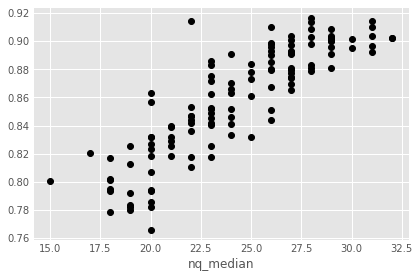

In [30]:
RES.set_index('nq_median').acc.plot(style='ko')

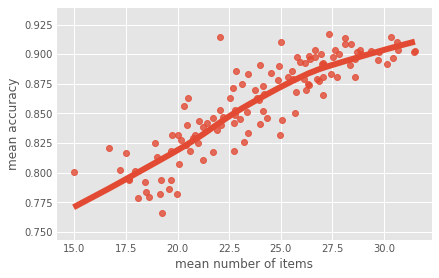

In [31]:
ax=sns.regplot(x=RES.nq_mean,y=RES.acc,ci=99.999,lowess=True)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
plt.savefig('accvsitemnumber_eegplus.png',dpi=200,bbox_inches='tight',transparent=True)

/home/ishanu/.local/lib/python3.7/site-packages/pandas/core/frame.py:9138: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  sort=sort,


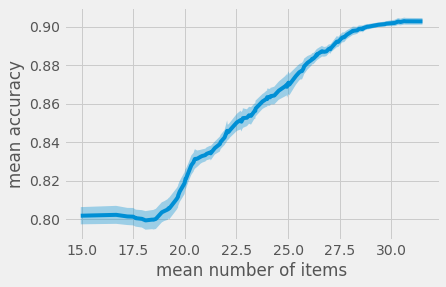

In [32]:
plt.style.use('fivethirtyeight')
df=pd.DataFrame(RES.set_index('nq_mean').acc)
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d

lowess = sm.nonparametric.lowess
df.index=df.index.astype(float)
df=df.sort_index()
S=.2
RUNS=50
DF=df
   
for i in range(RUNS):
    X=df.sample(int(np.round(S*df.index.size))).sort_index().reset_index().values

    z = lowess(X[:,1], X[:,0], frac= .25)
    f = interp1d(z[:,0], z[:,1])
    Y=f(X[:,0])
    DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
DF=DF.interpolate(method='index',order=3,limit_direction='both')
STD=pd.DataFrame(2.62*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot()
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.35)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
plt.savefig('accvsitemnumber1eegplus.png',dpi=200,bbox_inches='tight',transparent=True)

Text(0, 0.5, 'mean accuracy')

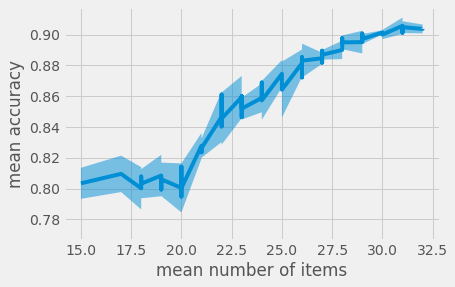

In [33]:
df=pd.DataFrame(RES.set_index('nq_median').acc)
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d

lowess = sm.nonparametric.lowess
df.index=df.index.astype(float)
df=df.sort_index()
S=.3
RUNS=8
DF=df

for i in range(RUNS):
    X=df.sample(int(np.round(S*df.index.size))).sort_index().reset_index().values

    z = lowess(X[:,1], X[:,0], frac= .35)
    f = interp1d(z[:,0], z[:,1])
    Y=f(X[:,0])
    DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
DF=DF.interpolate(method='index',order=3,limit_direction='both')
STD=pd.DataFrame(2.62*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot()
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.5)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
